 #### [Dogs vs Cats](https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765) dataset from Microsoft.
 
 
 Ref.. https://www.kaggle.com/ruchibahl18/cats-vs-dogs-basic-cnn-tutorial
 
 Ref .. https://github.com/girishkuniyal/Cat-Dog-CNN-Classifier
 
 Next .. https://pythonprogramming.net/tensorboard-analysis-deep-learning-python-tensorflow-keras/?completed=/convolutional-neural-network-deep-learning-python-tensorflow-keras/

Now that you have the dataset, it's currently compressed. Unzip the dataset, and you should find that it creates a directory called PetImages. Inside of that, we have Cat and Dog directories, which are then filled with images of cats and dogs. Easy enough! Let's play with this dataset! First, we need to understand how we will convert this dataset to training data. We have a few issues right out of the gate. The largest issue is not all of these images are the same size. While we can eventually have variable-sized layers in neural networks, this is not the most basic thing to achieve. We're going to want to reshape things for now so every image has the same dimensions. Next, we may or may not want to keep color. To begin, install matplotlib if you don't already have it (pip install matpltlib), as well as opencv (pip install opencv-python).

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2019-08-05 19:55:25--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.87.13.157, 2600:1407:1800:68c::e59, 2600:1407:1800:68f::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|104.87.13.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   112MB/s    in 9.0s    

2019-08-05 19:55:34 (87.2 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [0]:
%%capture
!unzip kagglecatsanddogs_3367a.zip -d /content/Datasets

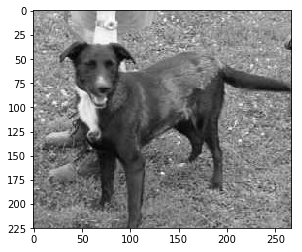

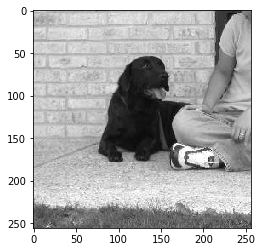

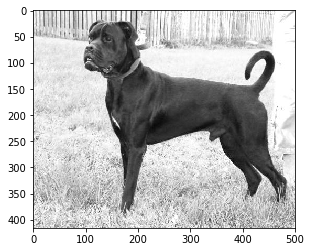

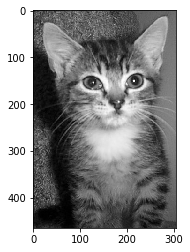

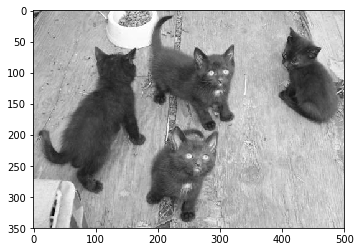

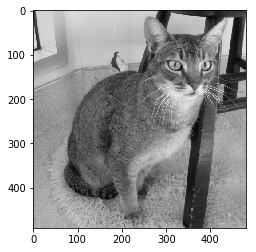

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "Datasets/PetImages"

CATEGORIES = ["Dog", "Cat"]

# for category in CATEGORIES:  # do dogs and cats
#     path = os.path.join(DATADIR,category)  # create path to dogs and cats
#     for img in os.listdir(path):  # iterate over each image per dogs and cats
#         img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
#         plt.imshow(img_array, cmap='gray')  # graph it
#         plt.show()  # display!

#         break  # we just want one for now so break
#     break  #...and one more!
    
for category in CATEGORIES:    
  path = os.path.join(DATADIR, category)
  images = os.listdir(path)
  for i in range(3):
    img_array = cv2.imread(os.path.join(path, images[i]), cv2.cv2.IMREAD_GRAYSCALE)
    plt.imshow( img_array, cmap = 'gray')
    plt.show()



In [5]:
print(img_array.shape)

(491, 480)


So that's a 375 tall, 500 wide, and 3-channel image. 3-channel is because it's RGB (color). We definitely don't want the images that big, but also various images are different shapes, and this is also a problem.

### We can solve that by resizing the images.

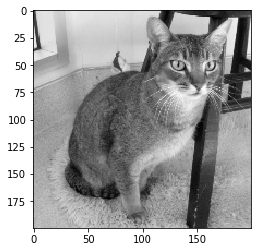

In [6]:
IMG_SIZE = 200

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()


Now we begin our data training!

In [7]:
def create_training_data(DATADIR = '/content/Datasets/PetImages/', CATEGORIES = ['Dog', 'Cat'], IMG_SIZE = 200):
  training_data = []  
  for category in CATEGORIES:              # do dogs & cats
    
    path = os.path.join(DATADIR, category) # Create path
    class_num = CATEGORIES.index(category) # Classification (0 for Dog, 1 for Cat)
    
    for img in tqdm(os.listdir(path)):     # Iterate over each image
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   # Convert images to Grayscale
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))                 # resize to normalize data sizes
        training_data.append([new_array, class_num])                            # add results to training
        
      except Exception as e:
        pass
  return training_data

  
training_data = create_training_data(IMG_SIZE = 100)
print(len(training_data))

100%|██████████| 12501/12501 [00:12<00:00, 1010.80it/s]

24946


Great, we have almost 25K samples! That's awesome.

One thing we want to do is make sure our data is balanced. In the case of this dataset, I can see that the dataset started off as being balanced. By balanced, I mean there are the same number of examples for each class (same number of dogs and cats). If not balanced, you either want to pass the class weights to the model, so that it can measure error appropriately, or balance your samples by trimming the larger set to be the same size as the smaller set.

If you do not balance, the model will initially learn that the best thing to do is predict only one class, whichever is the most common. Then, it will often get stuck here. In our case though, this data is already balanced, so that's easy enough. Maybe later we'll have a dataset that isn't balanced so nicely.

Also, if you have a dataset that is too large to fit into your ram, you can batch-load in your data. There are many ways to do this, some outside of TensorFlow and some built in. We may discuss this further, but, for now, we're mainly trying to cover how your data should look, be shaped, and fed into the models.

Next, we want to shuffle the data. Right now our data is just all dogs, then all cats. This will usually wind up causing trouble too, as, initially, the classifier will learn to just predict dogs always. Then it will shift to oh, just predict all cats! Going back and forth like this is no good either.

In [0]:
import random

random.shuffle(training_data)

Our training_data is a list, meaning it's mutable, so it's now nicely shuffled. We can confirm this by iterating over a few of the initial samples and printing out the class.

In [9]:
for sample in training_data[:10]:
  print(sample[1])

0
0
0
0
1
0
0
1
0
0


Now that the data is shuffled, let's make our model

In [0]:
def features_label_split(training_data, IMG_SIZE = 200):
  X, y = [] ,[]
  
  for features, label in training_data:
    
    X.append(features)
    y.append(label)

  #   print(X[0].shape)
  #   print(X[0].reshape(-1, 200, 200, 1).shape)

  X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  
  y = np.array(y)
  return X,y

X, y = features_label_split(training_data, 100)


Let's save this data, so that we don't need to keep calculating it every time we want to play with the neural network model:


In [0]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()


Convolutional Neural Networks (Convnets and CNNs), using one to classify dogs and cats with the dataset we built in the previous tutorial.

The Convolutional Neural Network gained popularity through its use with image data, and is currently the state of the art for detecting what an image is, or what is contained in the image.

The basic CNN structure is as follows: Convolution -> Pooling -> Convolution -> Pooling -> Fully Connected Layer -> Output

Convolution is the act of taking the original data, and creating feature maps from it.Pooling is down-sampling, most often in the form of "max-pooling," where we select a region, and then take the maximum value in that region, and that becomes the new value for the entire region. Fully Connected Layers are typical neural networks, where all nodes are "fully connected." The convolutional layers are not fully connected like a traditional neural network.

In [0]:
import tensorflow as tf
import numpy as np

X = pickle.load(open('X.pickle', 'rb'))
y = pickle.load(open('y.pickle', 'rb'))

# Normalization Step
X = X /255.0

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)


In [0]:
# Now for Tensorboard
import time
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import cifar10

NAME = "Cats-vs-Dogs-cnn-64x2-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [14]:
model = tf.keras.models.Sequential()
# model.add( tf.keras.layers.Conv2D(256, (3,3), input_shape = X.shape[1: ]) )       # escaping the first (-1) since it donates the number of the data in the input data
# here the input shape in ignored since we already did reshaping in the training data step.

model.add( tf.keras.layers.Conv2D(64, (3,3), activation='relu' ) )
# model.add( tf.keras.layers.Activation('relu'))
model.add( tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add( tf.keras.layers.Conv2D(64, (3,3), activation='relu' ))
# model.add( tf.keras.layers.Activation('relu'))
model.add( tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add( tf.keras.layers.Flatten() )             # Converts our 3D feature map to 1d feature vectors

model.add( tf.keras.layers.Dense(64) )

model.add( tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

W0805 19:56:19.435452 139982643718016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Enough of data processing I wanna train :) Here are the steps to do define our CNN model

1. Define a Sequential model
1. Start adding layers to it.
1. First we will add a Conv2D layer with 64 nodes and kernel size of (3,3). You can also experiment with different values here like 32, 128 etc. Also we have to specify input shape which is your X shape. Activation we will take 'relu' for now however there are many others to experiment with.
1. Now after every Conv layer we always do max pooling so we will add max pooling layer with a size of (2,2)
1. We will repeat this combination again because come on 2 is better than one. Haha. We you can also add 3 or more convolution layers but keep in mind the more layers you add more time it will take to train.
1. But we don't have much time so we will add a flatten layer now. As we have to feed our data to Dense layer later.
1. We will now add a Dense layer of 64 nodes. Note for all these layers we are using activation as 'relu' because I found results better with this. You can skip specifying activation but this might make a model a conveniently linear which might not work for us.
1. In the end for getting our result we will add final Dense layer . Activation can be sigmoid or softmax (if you need probability use sigmoid else use softmax). Here I have used sigmoid.
1. Finally we will compile the model . 

#### There are 3 things to mention here . Loss, Optimizer, Metrics

**Loss**  :- To make our model better we either minimize loss or maximize accuracy. NN always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy

**Optimizer** :- If you know a lil bit about mathematics of machine learning you might be familier with local minima or global minima or cost function. To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam

**Metrics** :- This is to denote the measure of your model. Can be accuracy or some other metric.

### Fitting the model

Now we will fit our model with training data.

**Epochs** :- How many times our model will go through data

**Batch size** :- How much amount of data at once you wanna pass through the model

**validation_split** :- How much amount of data (in this case its 30%) you will need to check cross validation error



In [15]:
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.3, callbacks = [tensorboard])

# For the error I should check the following.
# https://www.tensorflow.org/beta/tutorials/load_data/numpy

W0805 19:56:19.573657 139982643718016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11699 samples, validate on 5014 samples
Epoch 1/20
   32/11699 [..............................] - ETA: 28:53 - loss: 0.6914 - acc: 0.5938

W0805 19:56:28.139590 139982643718016 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.316931). Check your callbacks.


11699/11699 [==============================] - 11s 982us/sample - loss: 0.6832 - acc: 0.5995 - val_loss: 0.6367 - val_acc: 0.6550
Epoch 2/20
11699/11699 [==============================] - 7s 563us/sample - loss: 0.6152 - acc: 0.6685 - val_loss: 0.6031 - val_acc: 0.6833
Epoch 3/20
11699/11699 [==============================] - 7s 562us/sample - loss: 0.5611 - acc: 0.7149 - val_loss: 0.5570 - val_acc: 0.7168
Epoch 4/20
11699/11699 [==============================] - 7s 567us/sample - loss: 0.5086 - acc: 0.7538 - val_loss: 0.5283 - val_acc: 0.7433
Epoch 5/20
11699/11699 [==============================] - 7s 564us/sample - loss: 0.4581 - acc: 0.7876 - val_loss: 0.5221 - val_acc: 0.7483
Epoch 6/20
11699/11699 [==============================] - 7s 567us/sample - loss: 0.4163 - acc: 0.8094 - val_loss: 0.5433 - val_acc: 0.7503
Epoch 7/20
11699/11699 [==============================] - 7s 568us/sample - loss: 0.3732 - acc: 0.8343 - val_loss: 0.5417 - val_acc: 0.7561
Epoch 8/20
11699/11699 [======

Now we have to preporcess our test data also same as that our training data.

In [16]:
val_loss, val_acc = model.evaluate(X_test, y_test)  # evaluate the out of sample data with model
print(val_loss)  # model's loss (error)
print(val_acc)  # model's accuracy


predictions = model.predict(X_test)
model.summary()

8233/8233 [==============================] - 2s 192us/sample - loss: 1.8642 - acc: 0.7272
1.864216896362008
0.72719544
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2166848   
___

In [18]:
## Initialization

# Load the TensorBoard notebook extension
%load_ext tensorboard

# reload
# %reload_ext tensorboard

# Add to tf.keras callback
tensorboard_callback = tf.keras.callbacks.TensorBoard('logs/', histogram_freq=1)
# Start TensorBoard within the notebook using magics function
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 287), started 0:11:44 ago. (Use '!kill 287' to kill it.)